# 0. Importing packages

In [1]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434','#3EBCD2','#379A8B','#9A607F', '#B4BA39']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from scipy.interpolate import interp1d

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# 1. Solving for steady state

The model to be solved can be written as:
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t N_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t N_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{B}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{B}
\\
\mathcal{H}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{H}
\\
\varphi N_t^{\nu} \frac{1}{\theta}\left(C_{t}^\theta H_t^{1-\theta}\right)^\sigma\left(\frac{C_{t}}{H_t}\right)^{1-\theta} - w_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\quad t = 0, 1, \dots
$$

## 1.1. Household/HA block

Let's first construct our household/HA block to be used for both the steady state DAG and the transition DAG 

In [322]:
# load the HA block
hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
# hh1 = hh1.add_hetoutputs([utils.compute_weighted_mpc])

print(f'Inputs: {hh1.inputs}')
print(f'Macro outputs: {hh1.outputs}')
print(f'Micro outputs: {hh1.internals}')

Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'qh_lag', 'r', 'alpha', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Div', 'Tax']
Macro outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Vh_bhat', 'Vb_bhat', 'h_bhat', 'b_bhat', 'c_bhat', 'uce_bhat', 'chi', 'Psi1', 'b_bhat_grid', 'h_bhat_grid', 'k_grid', 'e_grid', 'pi_e', 'z_grid']


## 1.2. Other blocks for steady state

Now the other blocks for the model can be defined

In [2]:
@simple
def firm(N, w, Z, pi, mu, kappa):
    # N = Y / Z
    Y = Z * N
    Div = Y - w * N - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return Y, Div

@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, BBAR):
    Tax = r * BBAR
    return Tax

@simple
def wage_res(C_BHAT, H_BHAT, N, varphi, nu, theta, sigma, w):
    wage_res = varphi * N ** nu * 1 / theta * (C_BHAT**theta*H_BHAT**(1-theta))**sigma * (C_BHAT/H_BHAT)**(1-theta) - w
    return wage_res

@simple
def mkt_clearing(B_BHAT, C_BHAT, Y, BBAR, pi, mu, kappa, HBAR, H_BHAT, CHI, qh, gamma):
    asset_mkt = BBAR + gamma*qh*H_BHAT - B_BHAT
    goods_mkt = Y - C_BHAT - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y - CHI
    house_mkt = HBAR - H_BHAT
    return asset_mkt, goods_mkt, house_mkt

@simple 
def qhouse_lag(qh):
    qh_lag = qh(-1)
    return qh_lag

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

## 1.3. Creating the model and solving for steady state

In [324]:
blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'N', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'BBAR', 'varphi', 'nu', 'HBAR']
Outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'w', 'qh_lag']


In [415]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

calibration = {'gamma': 0.8, 'theta': 0.89, 'sigma': 2.5, 'alpha': 2.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 1, 'nB': 60, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 0.5, 'HBAR': 1.0}

# calibration['sigma'] = 4.0
calibration['theta'] = 0.83

# Calibrated parameters: beta (for goods market clearing), qh (for house market clearing), phi (for the wage schedule), w (for the Philips curve)
unknowns_ss = {'beta': 0.986, 'varphi': 0.8, 'qh': 5.0}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss =  hank_ss.steady_state(ss0)

Solving the model with seperability between housing and nondurable consumption

In [106]:
# load the HA block and add inputs
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]
hank_ss_sep = create_model(blocks_ss, name="One-Asset HANK SS")

calibration2 = {'gamma': 0.8, 'theta': 0.08, 'sigma': 1.0, 'alpha': 1.0, 'bmax': 45,
               'hmax': 5.0, 'kmax': 1, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 5.6, 'HBAR': 1.0}

unknowns_ss = {'beta': 0.986, 'varphi': 0.08345079332201338, 'qh': 8.845303164603399}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0_sep = hank_ss_sep.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")
ss_sep =  hank_ss_sep.steady_state(ss0_sep)

In [107]:
print(f"beta: {ss_sep['beta']}")
print(f"varphi: {ss_sep['varphi']}")
print(f"SS qh: {ss_sep['qh']}")
print(f"qh*H/(4*Y): {ss_sep['H_BHAT']*ss_sep['qh']/(4*ss_sep['Y'])}")

beta: 0.9894261269159249
varphi: 0.0666977392927745
SS qh: 15.454817627439152
qh*H/(4*Y): 3.8637044068597897


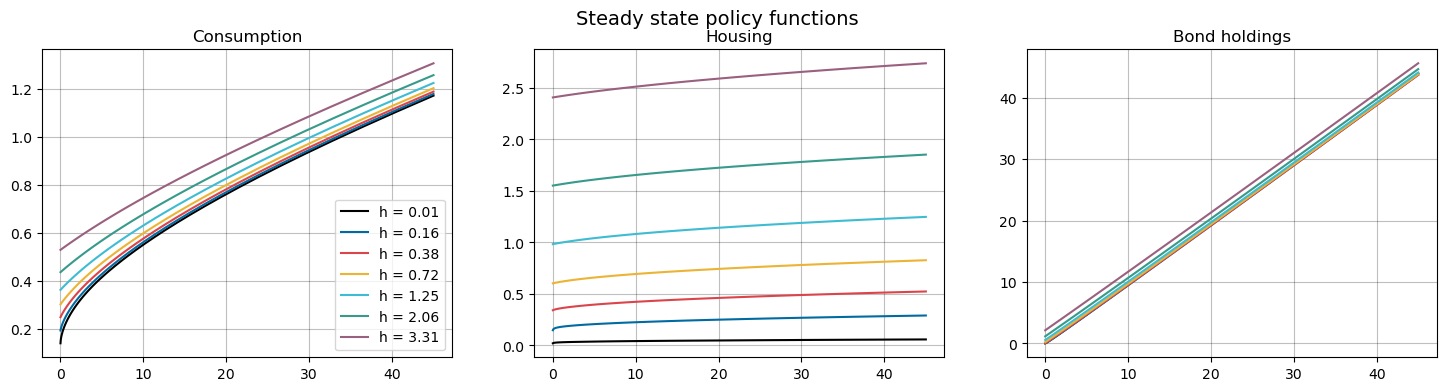

In [108]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

z_point = 0
for i_h in range(0, calibration2['nH'], 10):
    ax.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
            ss_sep.internals['hh_housecons_sep']['c_bhat'][z_point,:, i_h], label=f'h = {ss_sep.internals["hh_housecons_sep"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['b_bhat'][z_point,:, i_h])

ax.legend()
ax.set_title('Consumption')
ax2.set_title('Housing')
ax3.set_title('Bond holdings')
fig.suptitle('Steady state policy functions', fontsize=14)

plt.show()

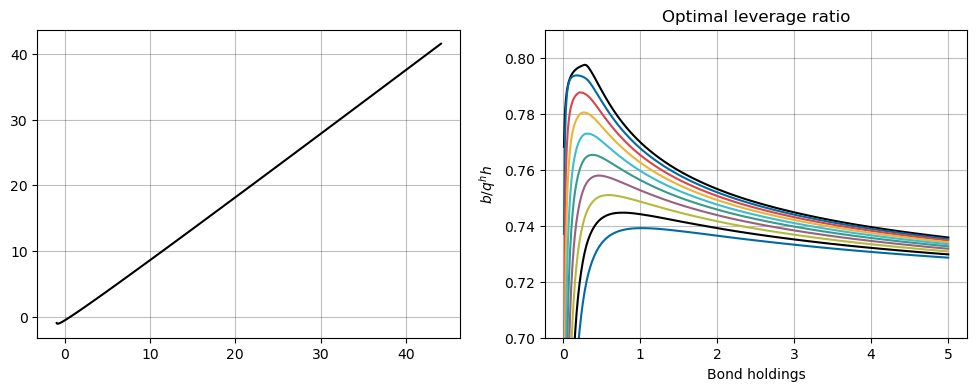

In [113]:
# low_inc_dist = ss.internals['hh_housecons']['D'][0,:,:]
# b_dist = low_inc_dist - 
z_point = 0
b_point = 5
h_point = 5

b_endo = ss_sep.internals['hh_housecons_sep']['b_bhat_grid'][None,:] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat_grid'][:,None]
b_polfunc = ss_sep.internals['hh_housecons_sep']['b_bhat'] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat']
leverage_polfunc = -b_polfunc / (ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax.plot(b_endo[h_point,:], b_polfunc[z_point,:, h_point])

# plot 2: leverage ratio
for iB in range(0, calibration2['nB']-40, 1):
    ax2.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], leverage_polfunc[z_point, iB, :])

ax2.set_ylim(0.7, ss_sep['gamma']+0.01)
ax2.set_title('Optimal leverage ratio')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel(r'$b / q^h h$')
plt.show()

In [50]:
print(leverage_polfunc[z_point, :, 1])
print(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'])

[  0.77385438   0.77658      0.74552787   0.70592427   0.6545478
   0.595657     0.52729495   0.45062083   0.36712456   0.27690556
   0.17754494   0.06801182  -0.0518597   -0.18396509  -0.32869489
  -0.48761119  -0.66197948  -0.85216936  -1.0540773   -1.26776424
  -1.49957703  -1.75072106  -2.02343997  -2.32018344  -2.64376108
  -2.99206527  -3.34970719  -3.73176588  -4.14556413  -4.59587272
  -5.08521306  -5.5979753   -6.12309211  -6.69196694  -7.31144423
  -7.97274202  -8.64112834  -9.35859974 -10.13763577 -10.95147202
 -11.78412988 -12.69446443 -13.64567082 -14.61782366 -15.66898895
 -16.75951818 -17.90729032 -19.10989138 -20.35567866 -21.6683032 ]
[1.00000000e-02 3.97496455e-02 7.27772221e-02 1.09443905e-01
 1.50150665e-01 1.95342654e-01 2.45514070e-01 3.01213568e-01
 3.63050252e-01 4.31700341e-01 5.07914563e-01 5.92526364e-01
 6.86461020e-01 7.90745760e-01 9.06520996e-01 1.03505280e+00
 1.17774673e+00 1.33616323e+00 1.51203468e+00 1.70728432e+00
 1.92404732e+00 2.16469411e+00 2.43

### 1.3.1. Printing steady state results

In [416]:
print(f"Asset market clearing (untargeted): {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing: {ss['goods_mkt']: 0.2e}")
print(f"Housing market clearing: {ss['house_mkt']: 0.2e}")
print(f"Wage schedue residual: {ss['wage_res']: 0.2e}")
print(f"SS beta: {ss['beta']}")
print(f"SS qh: {ss['qh_lag']}")
print(f"SS qh: {ss['qh']}")
print(f"SS wage: {ss['w']}")
print(f"SS r: {ss['r']}")
print(f"SS Y: {ss['Y']}")
print(ss['varphi'])
print(f"H_BHAT: {ss['H_BHAT']}")
print(f"qh*H/(4*Y): {ss['H_BHAT']*ss['qh']/(4*ss['Y'])}")
print(ss['B_BHAT'] - ss['qh']*ss['H_BHAT']*ss['gamma'])

Asset market clearing (untargeted): -9.99e-07
Goods market clearing:  1.30e-13
Housing market clearing:  8.90e-14
Wage schedue residual: -2.62e-13
SS beta: 0.9851384554360866
SS qh: 39.93218592251581
SS qh: 39.93218592251581
SS wage: 0.8333333333333334
SS r: 0.004999999999999893
SS Y: 1.0
0.6922586450402942
H_BHAT: 0.999999999999911
qh*H/(4*Y): 9.983046480628063
0.500000998694162


## 1.4. Plotting the steady stage policy functions

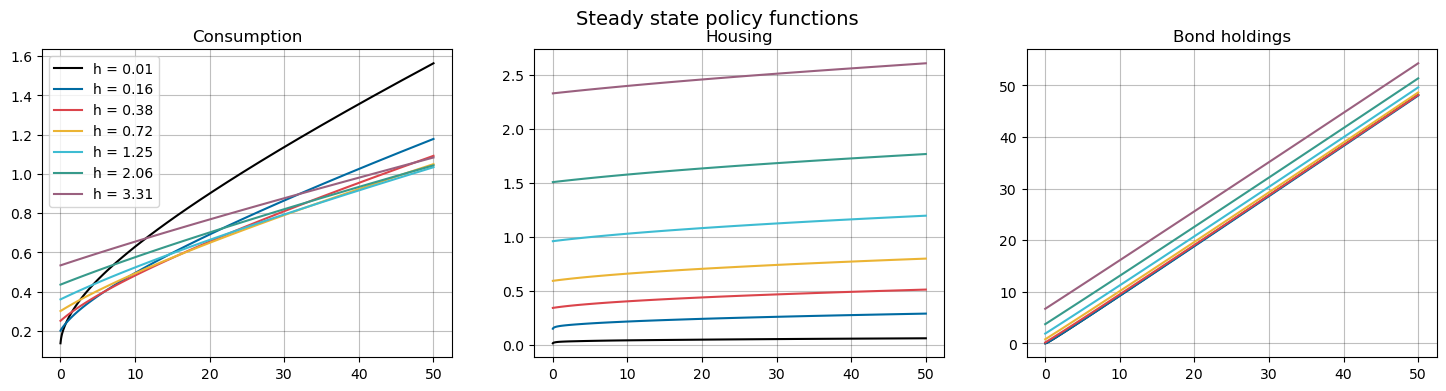

In [417]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

z_point = 0
for i_h in range(0, calibration['nH'], 10):
    ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['c_bhat'][z_point,:, i_h], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['b_bhat'][z_point,:, i_h])

ax.legend()
ax.set_title('Consumption')
ax2.set_title('Housing')
ax3.set_title('Bond holdings')
fig.suptitle('Steady state policy functions', fontsize=14)

plt.show()

Get the policy function for bond holdings

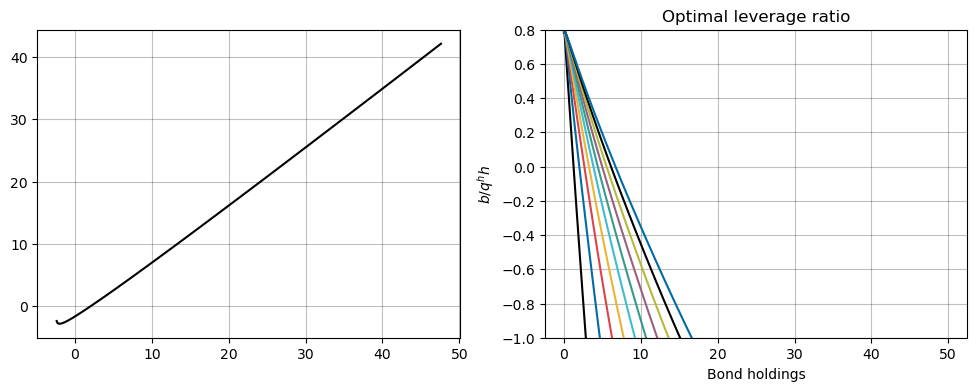

In [427]:
# low_inc_dist = ss.internals['hh_housecons']['D'][0,:,:]
# b_dist = low_inc_dist - 
z_point = 0
b_point = 5
h_point = 5

b_endo = ss.internals['hh_housecons']['b_bhat_grid'][None,:] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat_grid'][:,None]
b_polfunc = ss.internals['hh_housecons']['b_bhat'] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat']
leverage_polfunc = -b_polfunc / (ss['qh'] * ss.internals['hh_housecons']['h_bhat'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax.plot(b_endo[h_point,:], b_polfunc[z_point,:, h_point])

# plot 2: leverage ratio
for iB in range(0, calibration['nB']-50):
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], leverage_polfunc[z_point,:, iB])

ax2.set_ylim(-1.0, ss['gamma'])
ax2.set_title('Optimal leverage ratio')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel(r'$b / q^h h$')
plt.show()

## 1.5. Plotting the steady state distributions

### 1.5.1. Housing and bond holdings

In [328]:
bdmargdist = np.sum(ss.internals['hh_housecons']['D'],axis=0)
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
bmargcum = np.cumsum(b_margdist)

Text(0.5, 1.0, 'Cumulative distribution of bond holdings')

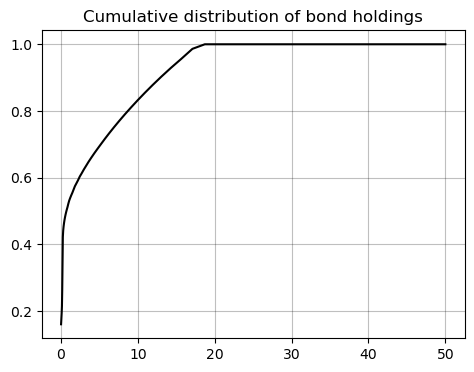

In [351]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)

ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], bmargcum)
ax.set_title('Cumulative distribution of bond holdings')

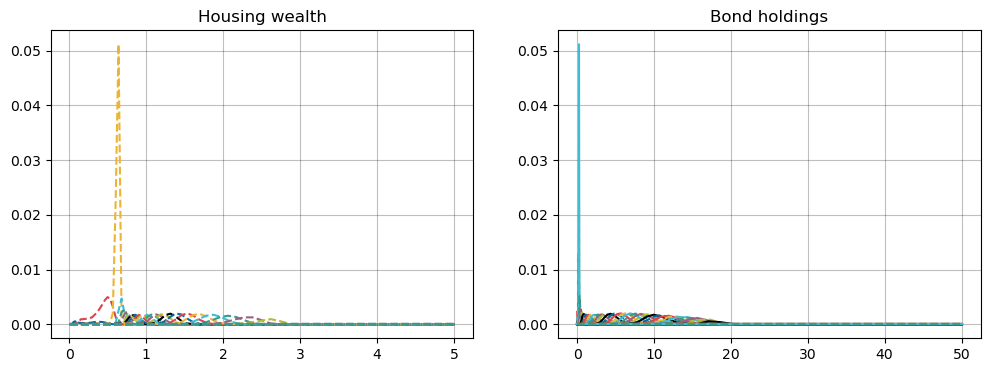

In [330]:
z_point = 1
h_point = 66

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i_h in range(0, calibration['nB'], 1):
    if i_h%2 == 0:
        # ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :])
        pass
    else:
        ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :], ls = '--')

for i_h in range(0, calibration['nH'], 1):
    if i_h%2 == 0:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h])
    else:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h], ls = '--')

ax.set_title('Housing wealth')
ax2.set_title('Bond holdings')
plt.show()

### 1.5.2. MPCs

mean MPC: 0.110


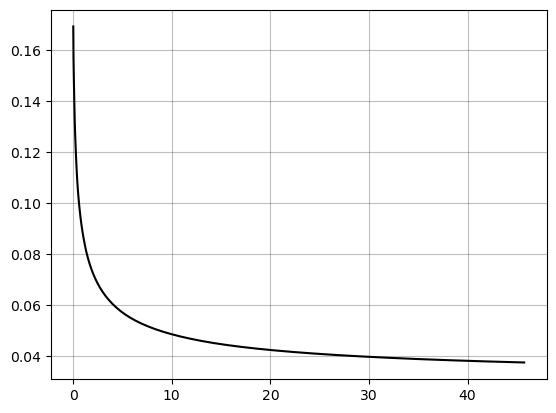

In [331]:
# MPC
MPC = np.zeros(ss.internals['hh_housecons']['D'].shape)
dc = (ss.internals['hh_housecons']['c_bhat'][:,1:,:]-ss.internals['hh_housecons']['c_bhat'][:,:-1,:])
dm = (1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,1:,np.newaxis]-(1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,:-1,np.newaxis]
MPC[:,:-1,:] = dc/dm
MPC[:,-1,:] = MPC[:,-1,:] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.internals['hh_housecons']['D'])


h_point = 1
print(f'mean MPC: {mean_MPC:.3f}')
fig, ax = plt.subplots()
ax.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],MPC[1,:-1,h_point])
plt.show()

# 2. Transitional dynamics

## 2.1. Building the DAG for transitional dynamics

Have to do a sligth modification of the DAG for transitional dyanmics, because the `nkpc_ss` block is not valid for anything but steady state

In [332]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc, qhouse_lag]
hank = create_model(blocks, name="Housing HANK")

Checking that the steady state DAG created above is valid

In [333]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

## 2.2. Plotting the DAG for the model

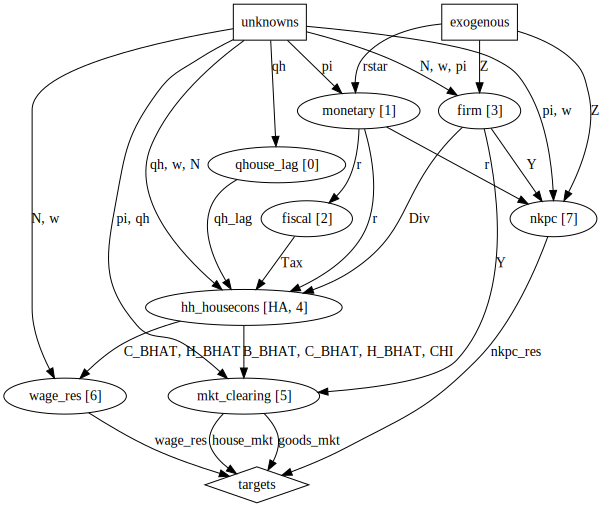

In [334]:
from sequence_jacobian import drawdag
inputs = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

drawdag(hank, inputs, unknowns, targets)

## 2.3. Computing impulse-response functions

### 2.3.1. Computing linear impulse-responses

In [335]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'N', 'qh', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'nkpc_res', 'qh_lag'], inputs=['rstar', 'Z']>


(300, 5)


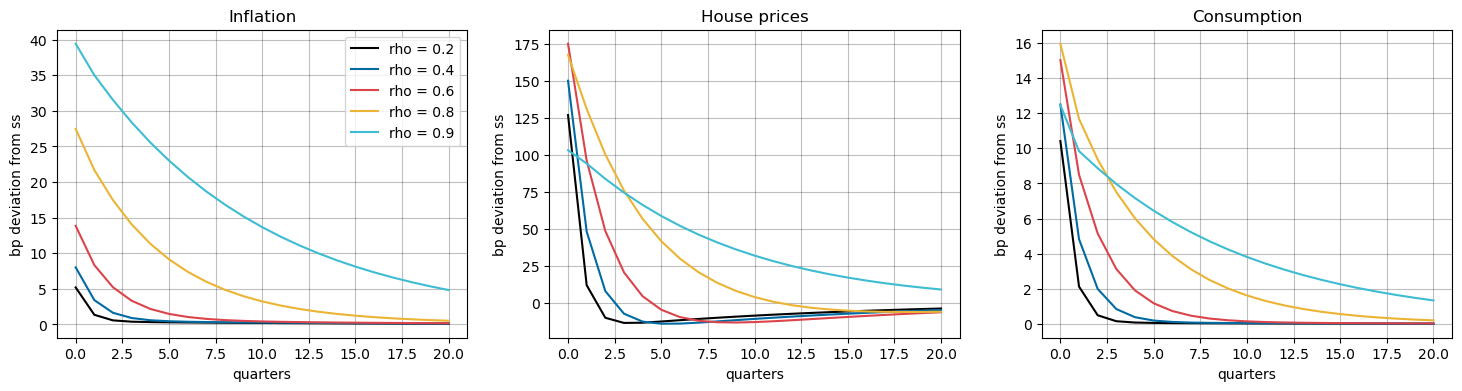

In [293]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
dqh = G['qh']['rstar'] @ drstar
dN = G['C_BHAT']['rstar'] @ drstar
ax.plot(10000 * dpi[:21])
ax.set_title('Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend([f'rho = {rho}' for rho in rhos])

ax2.plot(10000 * dqh[:21])
ax2.set_title('House prices')
ax2.set_xlabel('quarters')
ax2.set_ylabel('bp deviation from ss')

ax3.plot(10000 * dN[:21])
ax3.set_title('Consumption')
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')

plt.show()

Now, I'll compute what happens to leverage in the economy

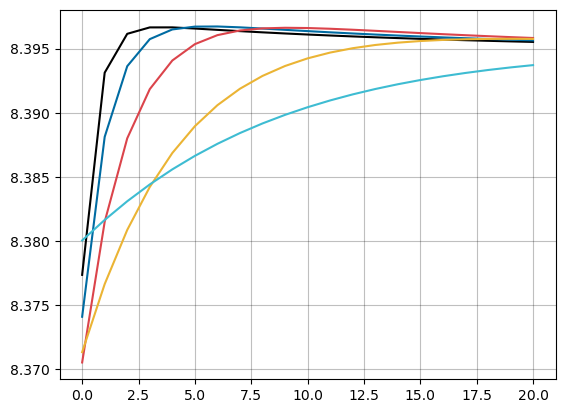

In [346]:
qh_lag_level = G['qh']['rstar'] @ drstar + ss['qh']
B_BHAT_level = G['B_BHAT']['rstar'] @ drstar + ss['B_BHAT']
B_level = B_BHAT_level - ss['gamma']*qh_lag_level*ss['H_BHAT']
leverage = B_level/(qh_lag_level*ss['H_BHAT'])

plt.plot(100*leverage[:21])
# plt.plot(B_level)
# plt.ylim(0.08, 0.1)
plt.show()

In [336]:
rho_r, sig_r = 0.61, -0.0025
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

dict_keys(['rstar', 'pi', 'w', 'N', 'qh', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'nkpc_res', 'qh_lag'])


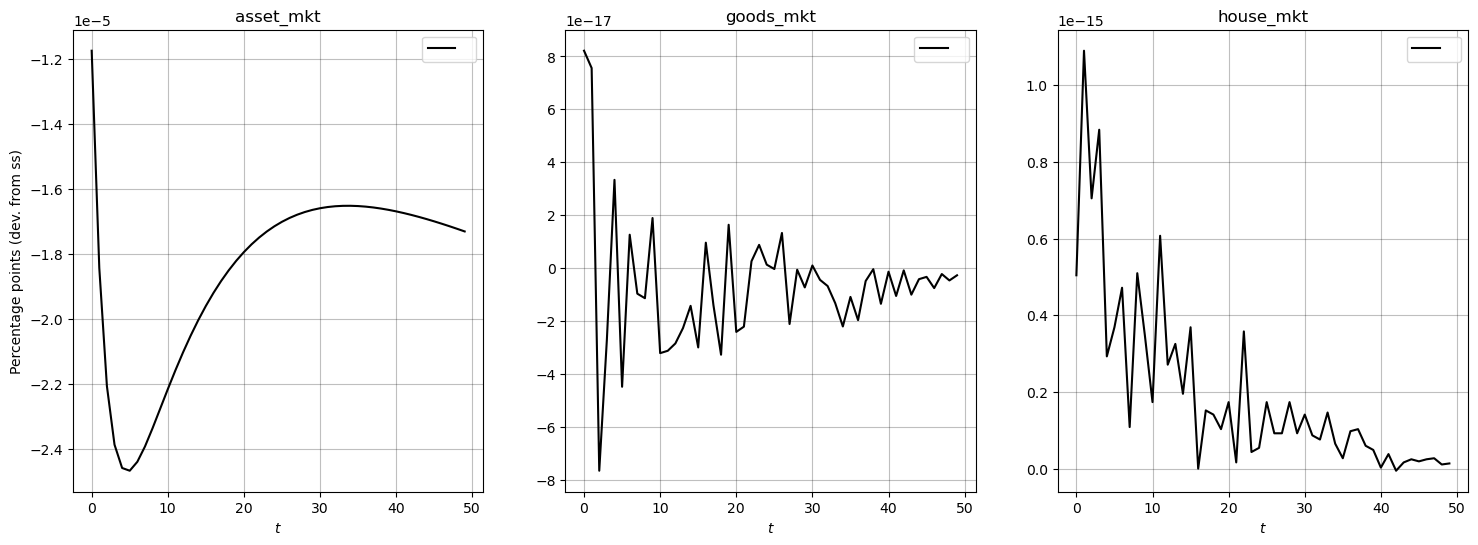

In [337]:
print(td_lin.keys())

# plt.plot(td_lin['asset_mkt'][:21])
utils.show_irfs([td_lin], ['asset_mkt', 'goods_mkt', 'house_mkt'])

### 2.3.2. Computing the non-linear impulse-response functions

Solving Housing HANK for ['pi', 'w', 'N', 'qh'] to hit ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for goods_mkt is 1.88E-03
   max error for wage_res is 4.81E-03
   max error for house_mkt is 2.31E-02
On iteration 1
   max error for nkpc_res is 1.30E-06
   max error for goods_mkt is 1.51E-04
   max error for wage_res is 4.06E-05
   max error for house_mkt is 3.35E-04
On iteration 2
   max error for nkpc_res is 7.94E-08
   max error for goods_mkt is 1.11E-06
   max error for wage_res is 7.00E-07
   max error for house_mkt is 4.53E-06
On iteration 3
   max error for nkpc_res is 1.01E-09
   max error for goods_mkt is 7.82E-09
   max error for wage_res is 1.01E-08
   max error for house_mkt is 1.37E-08
On iteration 4
   max error for nkpc_res is 8.81E-12
   max error for goods_mkt is 7.71E-11
   max error for wage_res is 4.96E-11
   max error for house_mkt is 2.55E-11
Solving Housing HANK for ['pi', 'w', 'N', 'qh'] t

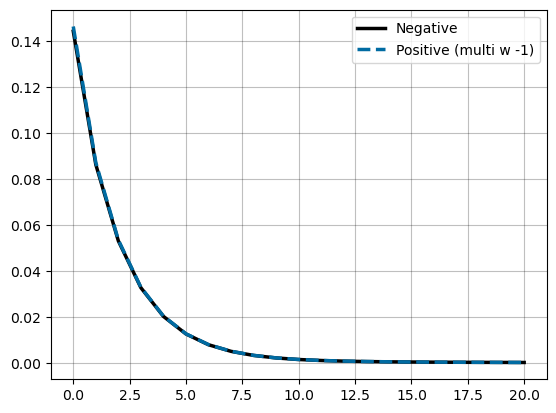

In [342]:
rho_r, sig_r = 0.61, 0.0025
rstar_shock_path_pos = {"rstar": sig_r * rho_r ** (np.arange(T))}
rstar_shock_path_neg = {"rstar": -sig_r * rho_r ** (np.arange(T))}

td_nonlin_pos = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path_pos)
td_nonlin_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path_neg)

dC_nonlin_neg = 100 * td_nonlin_neg['C_BHAT']
dC_nonlin_pos = 100 * td_nonlin_pos['C_BHAT']

plt.plot(dC_nonlin_neg[:21], label='Negative', linestyle='-', linewidth=2.5)
plt.plot(-1*dC_nonlin_pos[:21], label='Positive (multi w -1)', linestyle='--', linewidth=2.5)
plt.legend()
plt.show()

# Appendix A. Debugging the policy functions

## A.1. Setting up the same calibration as for general equilibrium

In [ ]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

b_bhat_grid, h_bhat_grid, k_grid, e_grid, Pi, b_grid = utils.make_grids(bmax, hmax, kmax, nB, nH, nK, nZ, rho_z, sigma_z, gamma, qh_lag)
z_grid = utils.income(e_grid, tax, w, N)

# use backward induction to solve for the steady state policy functions
Vh_p, Vb_p, h_bhat, b_bhat, c_bhat, _ = utils.policy_ss(Pi, h_bhat_grid, b_bhat_grid, z_grid, e_grid, k_grid, beta, 
                                         gamma, theta, sigma, qh, qh_lag, r, alpha, tol=1E-8, max_iter=5_000, debug = False)

c, h, b, b_endo = utils.bhat_to_b(h_bhat_grid, b_bhat_grid, b_grid, z_grid, c_bhat, h_bhat, gamma, alpha, r, qh, qh_lag)